In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
company = 'UBER'
stock_data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/UBER stock.csv", parse_dates=['Date'], sep=',', index_col='Date')

# Plotting UBER stock closing prices

Text(0.5, 1.0, 'UBER stock closing price')

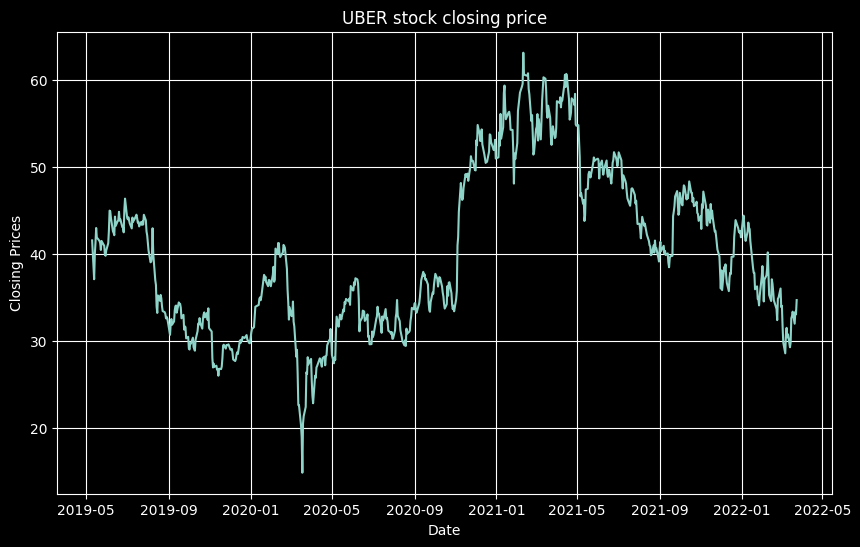

In [5]:
df_close = stock_data['Close']
plt.style.use('dark_background')
plt.figure(figsize=(10,6))
plt.grid()
plt.plot(df_close)
plt.xlabel('Date')
plt.ylabel('Closing Prices')
plt.title('UBER stock closing price')

In [6]:
def test_stationarity(timeseries):
    '''
    Input: timeseries (dataframe): timeseries for which we want to study the stationarity
    '''

    rolmean = timeseries.rolling(20).mean()
    rolstd = timeseries.rolling(20).std()

    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value',\
                                             '#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

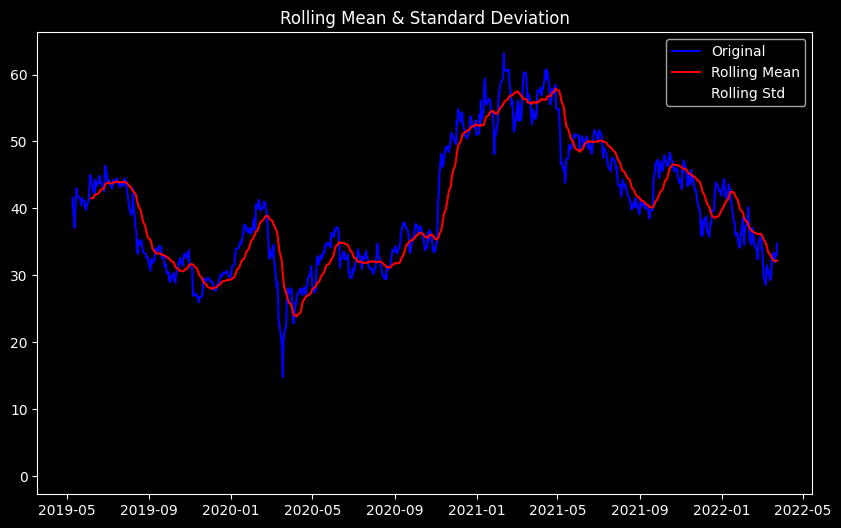

Results of Dickey-Fuller Test:
Test Statistic                  -2.044689
p-value                          0.267329
#Lags Used                       2.000000
Number of Observations Used    722.000000
Critical Value (1%)             -3.439440
Critical Value (5%)             -2.865551
Critical Value (10%)            -2.568906
dtype: float64


In [7]:
plt.figure(figsize = (10,6))
test_stationarity(df_close.head(2000))

<Figure size 640x480 with 0 Axes>

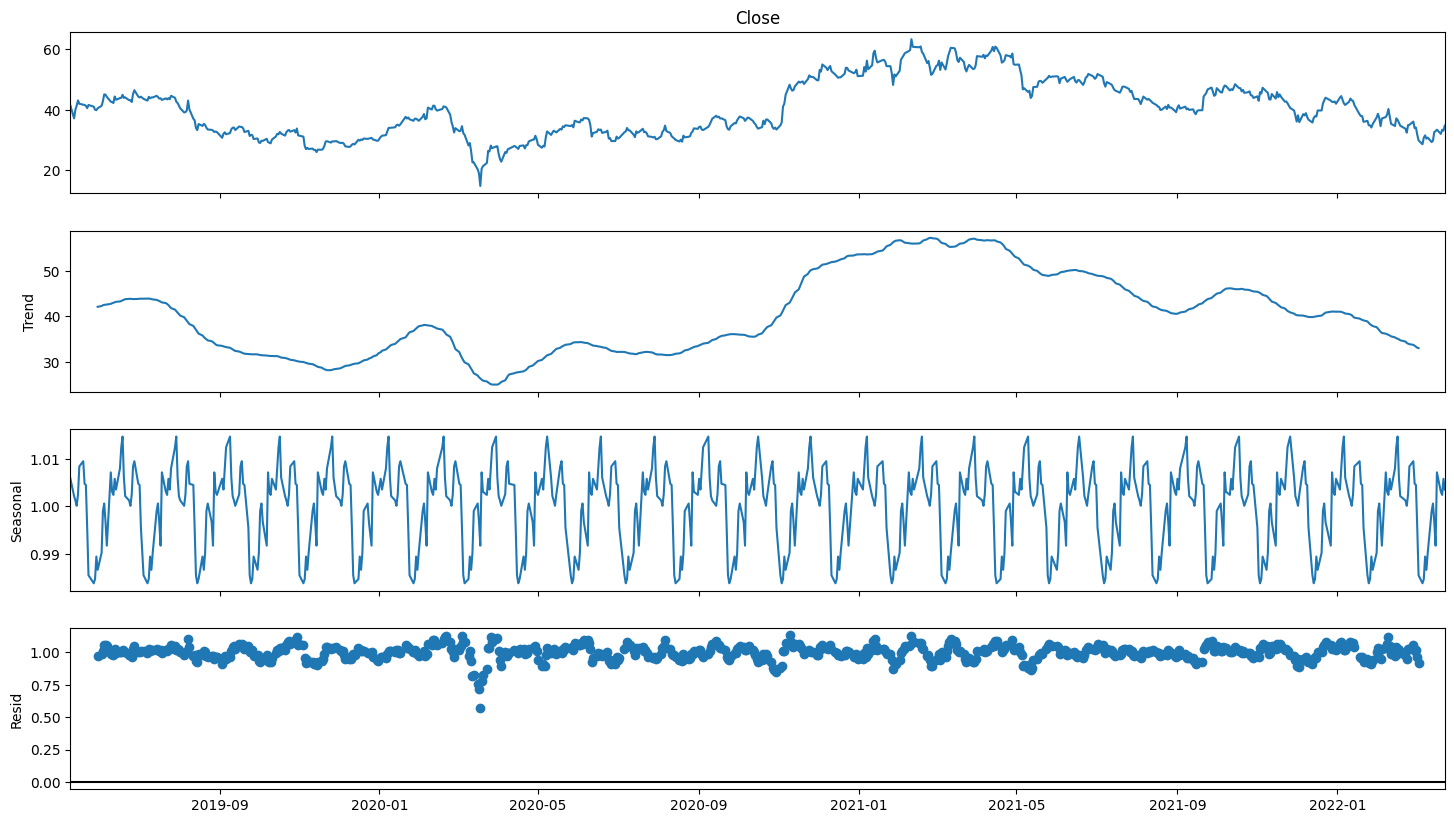

In [8]:
plt.style.use('default')
result = seasonal_decompose(df_close, model='multiplicative',period=28)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

Text(0.5, 1.0, 'Transformed data')

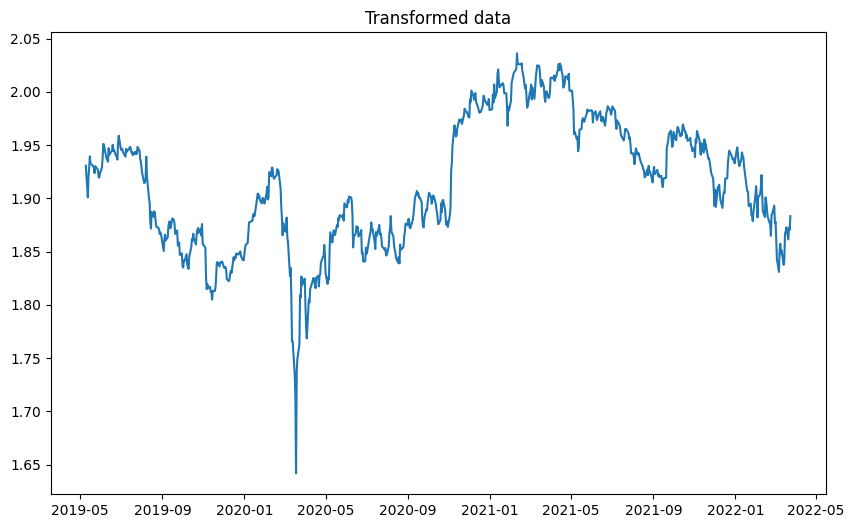

In [9]:
df_close_log = df_close.apply(np.log)
df_close_tf = df_close_log.apply(np.sqrt)
plt.style.use('default')
plt.figure(figsize = (10,6))
plt.plot(df_close_tf)
plt.title('Transformed data')

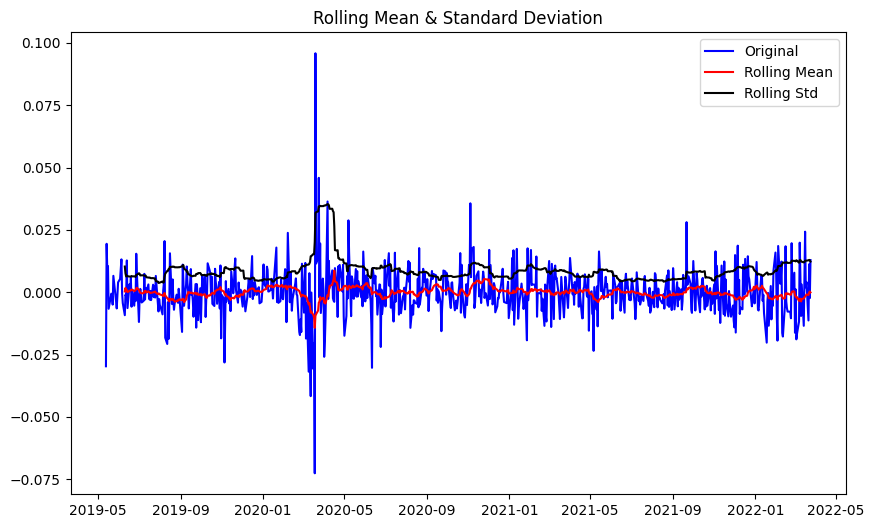

Results of Dickey-Fuller Test:
Test Statistic                -7.517646e+00
p-value                        3.865103e-11
#Lags Used                     1.100000e+01
Number of Observations Used    7.120000e+02
Critical Value (1%)           -3.439568e+00
Critical Value (5%)           -2.865608e+00
Critical Value (10%)          -2.568936e+00
dtype: float64


In [10]:
df_close_shift = df_close_tf - df_close_tf.shift()

df_close_shift.dropna(inplace=True)
plt.figure(figsize = (10,6))
test_stationarity(df_close_shift)

In [11]:
def preprocess_lstm(sequence, n_steps,n_features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix >= len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))
    return X, y

# Selecting prediction timeframe in days.

In [12]:
nb_days = 60

n_features = 1

X, y = preprocess_lstm(df_close_shift.to_numpy(), nb_days, n_features)

# Divide the dataset into training and test sets

In [13]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

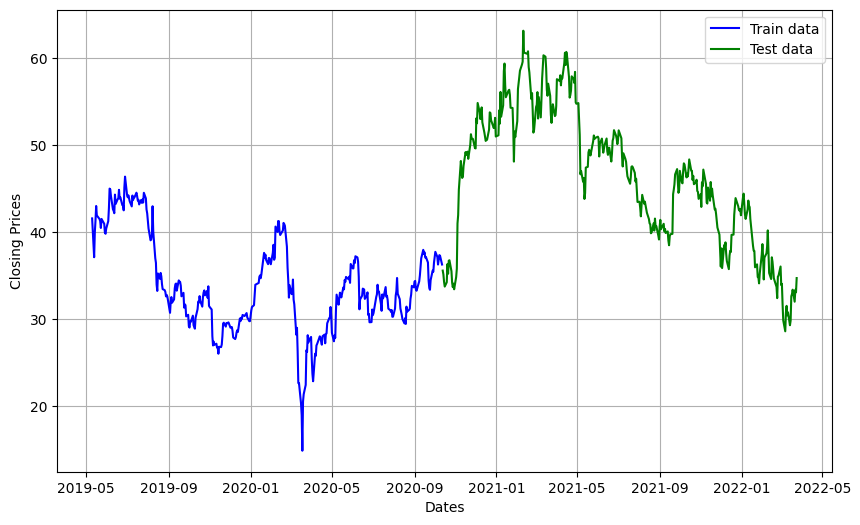

In [14]:
train_original = df_close.iloc[:-test_days]
test_original = df_close.iloc[-test_days:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.legend()

In [20]:
!pip install tensorflow
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense


def vanilla_LSTM():
    model = Sequential()
    # Use tf.keras.layers.LSTM to ensure you're using the correct LSTM layer
    model.add(tf.keras.layers.LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(1))
    return model

model = vanilla_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [21]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 1.5077e-04 - mean_absolute_error: 0.0088
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.5584e-04 - mean_absolute_error: 0.0083
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.4961e-04 - mean_absolute_error: 0.0074
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.6868e-04 - mean_absolute_error: 0.0082
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.3322e-04 - mean_absolute_error: 0.0072
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.2228e-04 - mean_absolute_error: 0.0075
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 1.4857e-04 - mean_absolute_error: 0.0078
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2128e-04 - mean_absolute_error: 0.0077
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.2979e-04 - mean_absolute_error: 0.0073
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.0979e-04 - mean_absolute_error: 0.0070

# Evaluating the model using test data

In [22]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)
print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8383e-05 - mean_absolute_error: 0.0063
Test MSE: 7.04590929672122e-05
Test MAE: 0.006516882684081793


# Prediction Analysis

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step


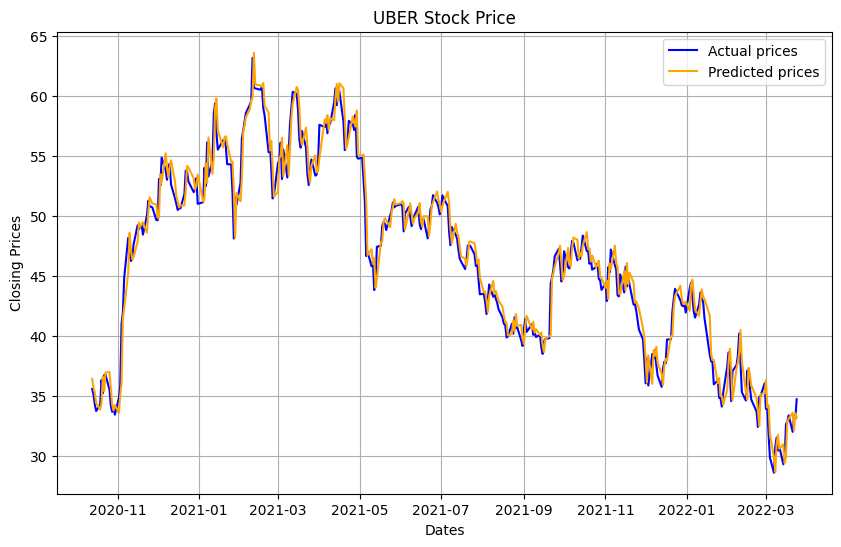

In [23]:
y_pred = model.predict(X_test)

pred_data = pd.DataFrame(y_pred[:,0], test_original.index,columns=['Close'])

pred_data['Close'] = pred_data['Close'] + df_close_tf.shift().values[-test_days:]

pred_data = pred_data.apply(np.square)
pred_data = pred_data.apply(np.exp)

plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original,'b',label='Actual prices')
plt.plot(pred_data, 'orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()

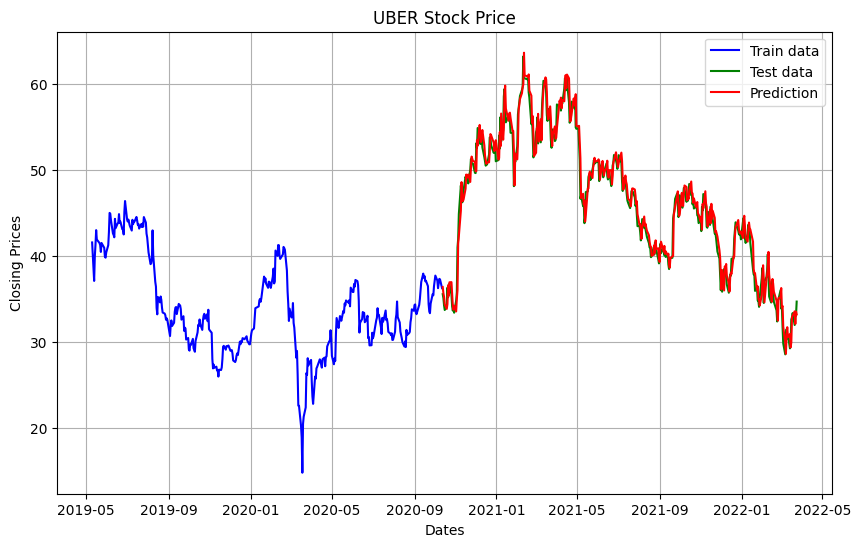

In [24]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(train_original, 'b', label='Train data')
plt.plot(test_original, 'g', label='Test data')
plt.plot(pred_data, 'red', label='Prediction')
plt.title(company + ' Stock Price')
plt.legend()

In [25]:
def preprocess_multistep_lstm(sequence, n_steps_in, n_steps_out, features):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        if out_end_ix > len(sequence):
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
        X.append(seq_x)
        y.append(seq_y)

    X = np.array(X)
    y = np.array(y)

    X = X.reshape((X.shape[0], X.shape[1], n_features))

    return X, y

# Time horizon for future prediction compared to the historical basis

In [26]:
n_steps_out = 10

nb_days = 60

n_features = 1

X, y = preprocess_multistep_lstm(df_close_shift.to_numpy(), nb_days, n_steps_out, n_features)


# Split the data set between the training set and the test set

In [27]:
test_days = 365

X_train, y_train = X[:-test_days], y[:-test_days]
X_test, y_test = X[-test_days:], y[-test_days:]

In [28]:
def vanilla_multistep_LSTM():
    model = Sequential()
    model.add(LSTM(units=50, input_shape=(nb_days, n_features)))
    model.add(Dense(n_steps_out))
    return model

In [29]:
model = vanilla_multistep_LSTM()
model.summary()
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=[tf.keras.metrics.MeanAbsoluteError()])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,910 (42.62 KB)

 Trainable params: 10,910 (42.62 KB)

 Non-trainable params: 0 (0.00 B)

In [30]:
model.fit(X_train,
          y_train,
          epochs=15,
          batch_size = 32)

Epoch 1/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 1.7275e-04 - mean_absolute_error: 0.0080
Epoch 2/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 1.4115e-04 - mean_absolute_error: 0.0076
Epoch 3/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.5438e-04 - mean_absolute_error: 0.0078
Epoch 4/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 1.6428e-04 - mean_absolute_error: 0.0080
Epoch 5/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 1.3348e-04 - mean_absolute_error: 0.0075
Epoch 6/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 1.5602e-04 - mean_absolute_error: 0.0077
Epoch 7/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.5192e-04 - mean_absolute_error: 0.0077
Epoch 8/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.8040e-04 - mean_absolute_error: 0.0082
Epoch 9/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 1.6676e-04 - mean_absolute_error: 0.0078
Epoch 10/15
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - loss: 1.4811e-04 - mean_absolute_error: 0.0076

In [31]:
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=32)

print("Test MSE:", results[0])
print("Test MAE:", results[1])

Evaluate on test data
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 6.8715e-05 - mean_absolute_error: 0.0063
Test MSE: 6.859072163933888e-05
Test MAE: 0.006384600885212421


12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


Text(0.5, 1.0, 'Original data vs predictions in the transformed space')

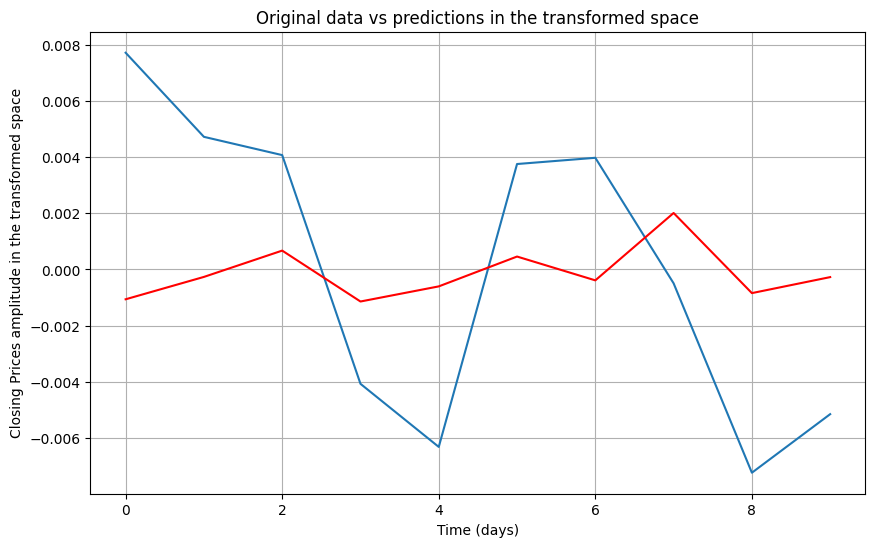

In [32]:
y_pred = model.predict(X_test)

the_day = 0
y_pred_days = y_pred[the_day,:]

plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(y_test[the_day,:],label='Orginal data - transformed')
plt.plot(y_pred_days, color='red',label='Predictions - transformed')
plt.xlabel('Time (days)')
plt.ylabel('Closing Prices amplitude in the transformed space')
plt.title('Original data vs predictions in the transformed space')

In [33]:
pred_diff_cumsum = y_pred_days.cumsum()

base_number = df_close_tf.values[-test_days+the_day+nb_days-1]
idx = test_original.iloc[the_day:the_day+n_steps_out].index

pred_tf = pd.Series(base_number, index=idx)
pred_tf = pred_tf.add(pred_diff_cumsum,fill_value=0)

print(pred_tf)

Date
2020-10-13    2.005844
2020-10-14    2.005579
2020-10-15    2.006250
2020-10-16    2.005109
2020-10-19    2.004507
2020-10-20    2.004967
2020-10-21    2.004579
2020-10-22    2.006589
2020-10-23    2.005747
2020-10-26    2.005475
dtype: float64


In [34]:
pred_log = pred_tf.apply(np.square)
pred = pred_log.apply(np.exp)
print(pred)

Date
2020-10-13    55.891456
2020-10-14    55.831989
2020-10-15    55.982550
2020-10-16    55.726958
2020-10-19    55.592524
2020-10-20    55.695101
2020-10-21    55.608553
2020-10-22    56.058728
2020-10-23    55.869743
2020-10-26    55.808774
dtype: float64


# Plotting actual prices vs predicted prices

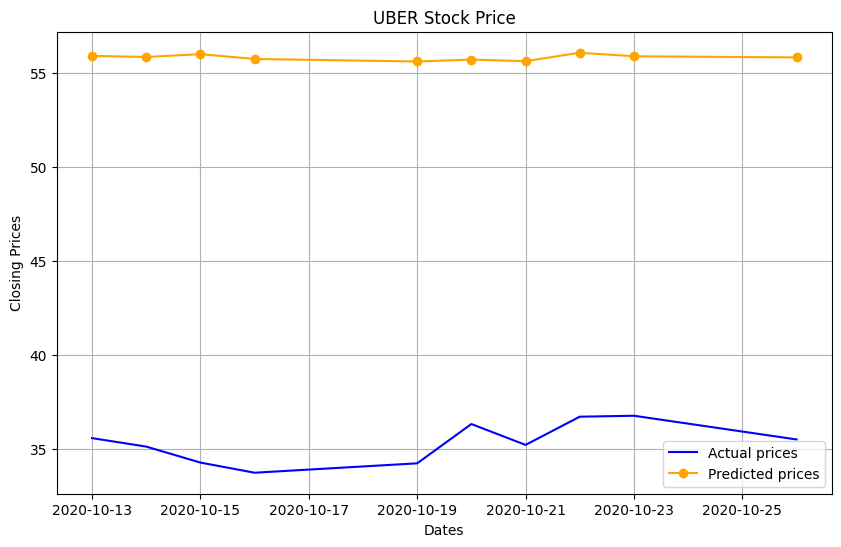

In [35]:
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(test_original.iloc[max(0,the_day-30):the_day+n_steps_out],'b',label='Actual prices')
plt.plot(pred, '-o',color='orange',label='Predicted prices')
plt.title(company + ' Stock Price')

plt.legend()